In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer

In [2]:
df =pd.read_csv('/content/ola_driver_scaler.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [3]:
df.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [4]:
df.isna().sum()

,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


In [5]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'],format='mixed')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'],format='mixed')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'],format='mixed')

In [6]:
num_vars = df.select_dtypes(np.number)
num_vars.drop(['Driver_ID','Gender'], axis = 1, inplace = True)
num_vars.columns

Index(['Age', 'Education_Level', 'Income', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [7]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)
data_new = pd.DataFrame(data_new)
data_new.columns = num_vars.columns

In [8]:
data_new.isnull().sum()

,0
Age,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


In [9]:
resultant_columns = list(set(df.columns).difference(set(num_vars)))
new_df = pd.concat([data_new, df[resultant_columns]], axis=1)
new_df.head()

,Age,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Gender,City,Dateofjoining,LastWorkingDate,MMM-YY,Driver_ID
0,28.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,0.0,C23,2018-12-24,NaT,2019-01-01,1
1,28.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,0.0,C23,2018-12-24,NaT,2019-02-01,1
2,28.0,2.0,57387.0,1.0,1.0,0.0,2.0,0.0,C23,2018-12-24,2019-03-11,2019-03-01,1
3,31.0,2.0,67016.0,2.0,2.0,0.0,1.0,0.0,C7,2020-11-06,NaT,2020-11-01,2
4,31.0,2.0,67016.0,2.0,2.0,0.0,1.0,0.0,C7,2020-11-06,NaT,2020-12-01,2


In [10]:
new_df.isna().sum()

,0
Age,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0
Gender,52
City,0
Dateofjoining,0


In [11]:
df_x = new_df.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna().reset_index()
QR1 =  (new_df.groupby('Driver_ID').agg({'Quarterly Rating':'first','Income':'first'})[['Quarterly Rating','Income']]).reset_index()
QR2 =  (new_df.groupby('Driver_ID').agg({'Quarterly Rating':'last','Income':'last'})[['Quarterly Rating','Income']]).reset_index()
df_x = df_x.merge(QR1,on='Driver_ID')
df_x = df_x.merge(QR2,on='Driver_ID')
df_x.head()

,Driver_ID,LastWorkingDate,Quarterly Rating_x,Income_x,Quarterly Rating_y,Income_y
0,1,False,2.0,57387.0,2.0,57387.0
1,2,True,1.0,67016.0,1.0,67016.0
2,4,False,1.0,65603.0,1.0,65603.0
3,5,False,1.0,46368.0,1.0,46368.0
4,6,True,1.0,78728.0,2.0,78728.0


In [12]:
df_x['Rating_Change'] = np.select([df_x['Quarterly Rating_x'] < df_x['Quarterly Rating_y'],
                                 df_x['Quarterly Rating_x'] > df_x['Quarterly Rating_y'],df_x['Quarterly Rating_x'] == df_x['Quarterly Rating_y'],],['Increased', 'Decreased', 'Same'],
                                default='Unknown')
df_x['Promoted'] = np.where(df_x['Income_y'] <= df_x['Income_x'],0,1)
df_x['Income_Change'] = np.select([df_x['Income_y'] > df_x['Income_x'],df_x['Income_y'] == df_x['Income_x']],['Increased','Same'],default='Unknown')
df_x = df_x.drop(columns = ['LastWorkingDate','Quarterly Rating_x','Quarterly Rating_y','Income_x','Income_y'],axis=1)
df_x.head()

,Driver_ID,Rating_Change,Promoted,Income_Change
0,1,Same,0,Same
1,2,Same,0,Same
2,4,Same,0,Same
3,5,Same,0,Same
4,6,Increased,0,Same


In [13]:
df1 = new_df.copy()
df1 = df1.groupby('Driver_ID').agg({'MMM-YY':'count','Age':'max','Gender':'last','City':'last','Education_Level':'last',
                                    'Income':'last','Dateofjoining':'first','LastWorkingDate':'last','Joining Designation':'last',
                                    'Grade':'last','Total Business Value':'sum','Quarterly Rating':'last'}).reset_index()
df1.rename(columns={'MMM-YY':'No_of_Reportings'},inplace=True)
df1['Employment_Status'] = np.where(df1['LastWorkingDate'].isnull(), 0, 1)
df1['Age'] = df1['Age'].round().astype('Int64')
df1.reset_index(drop=True,inplace=True)
df_new = df1.merge(df_x,on='Driver_ID')
df_new.head()

,Driver_ID,No_of_Reportings,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Employment_Status,Rating_Change,Promoted,Income_Change
0,1,3,28,0.0,C23,2.0,57387.0,2018-12-24,2019-03-11,1.0,1.0,1715580.0,2.0,1,Same,0,Same
1,2,2,31,0.0,C7,2.0,67016.0,2020-11-06,NaT,2.0,2.0,0.0,1.0,0,Same,0,Same
2,4,5,43,0.0,C13,2.0,65603.0,2019-12-07,2020-04-27,2.0,2.0,350000.0,1.0,1,Same,0,Same
3,5,3,29,0.0,C9,0.0,46368.0,2019-01-09,2019-03-07,1.0,1.0,120360.0,1.0,1,Same,0,Same
4,6,5,31,1.0,C11,1.0,78728.0,2020-07-31,NaT,3.0,3.0,1265000.0,2.0,0,Increased,0,Same


In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   No_of_Reportings      2381 non-null   int64         
 2   Age                   2381 non-null   Int64         
 3   Gender                2381 non-null   float64       
 4   City                  2381 non-null   object        
 5   Education_Level       2381 non-null   float64       
 6   Income                2381 non-null   float64       
 7   Dateofjoining         2381 non-null   datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   2381 non-null   float64       
 10  Grade                 2381 non-null   float64       
 11  Total Business Value  2381 non-null   float64       
 12  Quarterly Rating      2381 non-null   float64       
 13  Employment_Status 

**Model Training**

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [16]:
df_model = df_new.copy()
df_model = df_model.drop(columns=['Dateofjoining','LastWorkingDate','City'],axis=1)

In [19]:
columns_to_encode = ['Rating_Change', 'Income_Change']
df_model = pd.get_dummies(df_model,columns = columns_to_encode,dtype='int64')

In [20]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Driver_ID                2381 non-null   int64  
 1   No_of_Reportings         2381 non-null   int64  
 2   Age                      2381 non-null   Int64  
 3   Gender                   2381 non-null   float64
 4   Education_Level          2381 non-null   float64
 5   Income                   2381 non-null   float64
 6   Joining Designation      2381 non-null   float64
 7   Grade                    2381 non-null   float64
 8   Total Business Value     2381 non-null   float64
 9   Quarterly Rating         2381 non-null   float64
 10  Employment_Status        2381 non-null   int64  
 11  Promoted                 2381 non-null   int64  
 12  Rating_Change_Decreased  2381 non-null   int64  
 13  Rating_Change_Increased  2381 non-null   int64  
 14  Rating_Change_Same      

In [21]:
X = df_model.drop(columns=['Employment_Status','Quarterly Rating','Joining Designation'],axis=1)
y = df_model['Employment_Status']

In [22]:
X.columns

Index(['Driver_ID', 'No_of_Reportings', 'Age', 'Gender', 'Education_Level',
       'Income', 'Grade', 'Total Business Value', 'Promoted',
       'Rating_Change_Decreased', 'Rating_Change_Increased',
       'Rating_Change_Same', 'Income_Change_Increased', 'Income_Change_Same'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1904, 14), (477, 14), (1904,), (477,))

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [26]:
y_train_resampled.value_counts()

,count
Employment_Status,
0,1289
1,1289


In [27]:
model = GradientBoostingClassifier(n_estimators=100,max_depth=3)
model.fit(X_train_resampled,y_train_resampled)

GradientBoostingClassifier()

In [28]:
y_pred = model.predict(X_test)
print('\033[1mClassification Report for Test data:\033[0m\n',classification_report(y_test,y_pred))
print('\033[1mClassification Report for Train data:\033[0m\n',classification_report(y_train_resampled,model.predict(X_train_resampled)))

Classification Report for Test data:
               precision    recall  f1-score   support

           0       0.77      0.65      0.71       150
           1       0.85      0.91      0.88       327

    accuracy                           0.83       477
   macro avg       0.81      0.78      0.79       477
weighted avg       0.83      0.83      0.83       477

Classification Report for Train data:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1289
           1       0.85      0.90      0.87      1289

    accuracy                           0.87      2578
   macro avg       0.87      0.87      0.87      2578
weighted avg       0.87      0.87      0.87      2578



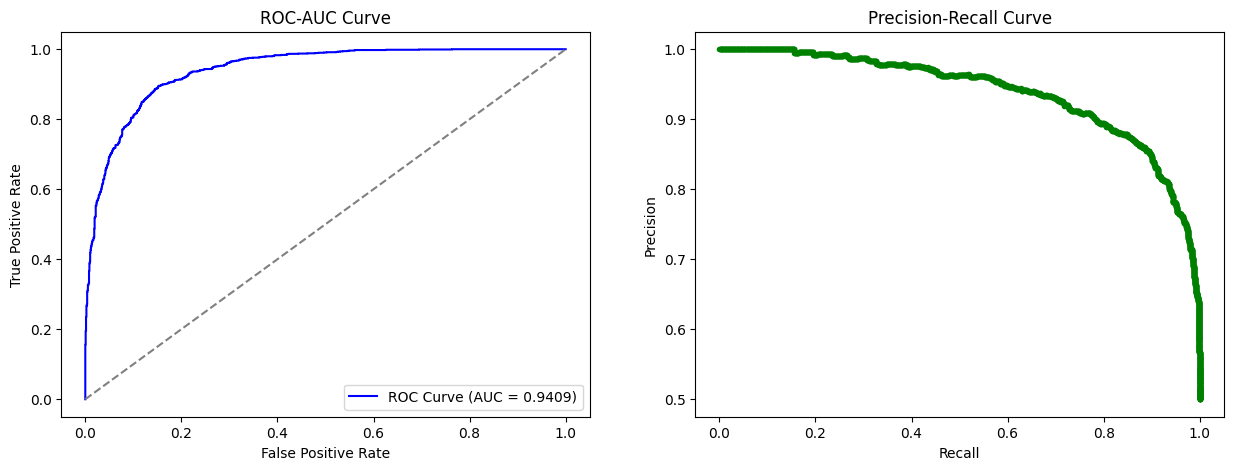

In [29]:
y_prob = model.predict_proba(X_train_resampled)[:, 1]
fpr, tpr, _ = roc_curve(y_train_resampled, y_prob)
auc_score = roc_auc_score(y_train_resampled, y_prob)
precision, recall, _ = precision_recall_curve(y_train_resampled, y_prob)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.subplot(1,2,2)
plt.plot(recall, precision, marker='.', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

**Saving the Model**

In [30]:
dummy_columns = df_model.columns.tolist()

In [31]:
dummy_columns

['Driver_ID',
 'No_of_Reportings',
 'Age',
 'Gender',
 'Education_Level',
 'Income',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating',
 'Employment_Status',
 'Promoted',
 'Rating_Change_Decreased',
 'Rating_Change_Increased',
 'Rating_Change_Same',
 'Income_Change_Increased',
 'Income_Change_Same']

In [32]:
import pickle
with open('Ola_Model.pkl', mode='wb') as f:
    pickle.dump((model, scaler, dummy_columns), f)